### Voice Analysis

#### - Ekstraksi Fitur Audio (MFCC)

1. Impor Library: Mengimpor librosa untuk pemrosesan audio, pandas untuk mengelola data, os untuk navigasi file, dan tqdm untuk menampilkan progress bar.

2. Definisi Fungsi extract_mfcc: Fungsi ini memuat file audio, kemudian menggunakan librosa.feature.mfcc untuk mengekstrak 40 MFCC (Mel-Frequency Cepstral Coefficients), yang merupakan fitur umum untuk pengenalan suara.

3. Pengambilan Rata-rata: Karena MFCC menghasilkan matriks (fitur per frame waktu), kode ini mengambil rata-ratanya (np.mean) untuk merangkum seluruh audio menjadi satu baris data (sebuah vektor dengan 40 angka).

4. Looping & Ekstraksi: Kode ini melakukan looping ke setiap file .wav di dalam subfolder buka dan tutup. Ia memanggil fungsi extract_mfcc untuk setiap file dan menyimpan hasilnya (40 fitur + 1 label) ke dalam sebuah list.

5. Penyimpanan: Terakhir, semua data yang terkumpul diubah menjadi DataFrame Pandas dan disimpan sebagai file voice_features.csv.

In [4]:
import os
import librosa
import numpy as np
import pandas as pd
from tqdm import tqdm

# Tentukan path ke DATASET AUGMENTASI Anda
augmented_path = "C:\\Dokumen\\PSD\\dataset\\voice_augmented"
categories = ["buka", "tutup"]
all_data = []

print(f"Memulai ekstraksi fitur MFCC dari {augmented_path}...")

def extract_mfcc(file_path):
    """Memuat file audio dan mengekstrak rata-rata MFCC."""
    try:
        audio, sr = librosa.load(file_path, sr=None)
        # Ekstrak 40 MFCC
        mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=40)
        # Ambil rata-ratanya untuk jadi 1 baris fitur
        mfccs_mean = np.mean(mfccs.T, axis=0)
        return mfccs_mean
    except Exception as e:
        print(f"Error memproses {file_path}: {e}")
        return None

# Proses semua 200 file
for category in categories:
    category_path = os.path.join(augmented_path, category)
    files = [f for f in os.listdir(category_path) if f.endswith('.wav')]
    
    for file_name in tqdm(files, desc=f"Memproses {category}"):
        file_path = os.path.join(category_path, file_name)
        features = extract_mfcc(file_path)
        
        if features is not None:
            # Tambahkan fitur dan labelnya
            all_data.append([*features, category])

print("\nEkstraksi fitur selesai.")

# Buat DataFrame Akhir
feature_cols = [f'mfcc_{i+1}' for i in range(40)]
column_names = feature_cols + ['label']
data = pd.DataFrame(all_data, columns=column_names)

print(data.head())

# Simpan ke CSV
data.to_csv("voice_features.csv", index=False)
print(f"Berhasil! Data fitur (200 baris) telah disimpan ke voice_features.csv")

Memulai ekstraksi fitur MFCC dari C:\Dokumen\PSD\dataset\voice_augmented...


Memproses tutup: 100%|██████████| 100/100 [00:00<00:00, 106.10it/s]


Ekstraksi fitur selesai.
       mfcc_1      mfcc_2     mfcc_3     mfcc_4    mfcc_5     mfcc_6  \
0 -353.894501  110.137138  22.485777  12.943505 -2.767408 -16.105215   
1 -357.250000  130.469009   0.674083   0.786324 -4.007336 -13.454900   
2 -353.400970  133.772141   2.290386  12.572845 -9.472692 -20.455582   
3 -193.380310   46.122730  22.087955   9.609308 -1.072038  -9.810766   
4 -218.956696   39.077824  14.391515   4.045373 -0.293725  -3.253300   

      mfcc_7    mfcc_8     mfcc_9   mfcc_10  ...   mfcc_32   mfcc_33  \
0 -15.346338 -7.141162   4.356388  2.749580  ... -4.711731 -0.776546   
1 -15.142923 -4.539568  11.625637 -4.350885  ...  0.540744 -1.414756   
2 -16.811853 -5.574747  12.576075 -8.611343  ... -1.330390 -1.328813   
3  -8.870459 -2.508450   2.221746 -0.931529  ... -2.283640 -1.558172   
4  -3.703411 -0.202437   4.908715  2.116869  ... -0.857442 -1.033415   

    mfcc_34   mfcc_35   mfcc_36   mfcc_37   mfcc_38   mfcc_39   mfcc_40  label  
0 -2.747962 -0.192043 -3.57

#### - Pembuatan Model (Random Forest)

1. Impor Library: Mengimpor pandas, joblib (untuk menyimpan model), dan berbagai modul dari sklearn (untuk membagi data, scaling, melatih model, dan evaluasi).

2. Memuat Data: Membaca file voice_features.csv yang dibuat oleh Sel 1.

3. Pemisahan Data: Memisahkan data menjadi fitur (X) dan label (y).

4. Split Data: Membagi dataset menjadi 80% data latih dan 20% data uji menggunakan train_test_split. Penggunaan stratify=y memastikan proporsi kelas "buka" dan "tutup" seimbang di kedua set.

5. Scaling Fitur: Menerapkan StandardScaler pada data fitur (X). Ini adalah langkah penting untuk menormalkan data sehingga model (seperti Random Forest) dapat bekerja lebih optimal. Scaler ini di-fit hanya pada data latih.

6. Pelatihan Model: Menggunakan RandomForestClassifier (sebuah model ensemble yang kuat) dan melatihnya (.fit()) menggunakan data latih yang sudah di-scale.

7. Evaluasi: Menguji model pada data uji yang belum pernah dilihat sebelumnya. Berdasarkan output, model ini mencapai akurasi 97.50%.

8. Penyimpanan: Menyimpan dua file penting ke disk menggunakan joblib.dump:

9. model_voice.joblib: File model Random Forest yang sudah terlatih.

10. scaler_voice.joblib: File scaler yang berisi informasi (mean/std) dari data latih. File ini sangat penting untuk memproses data baru (misalnya, input audio real-time di Streamlit) sebelum diberikan ke model untuk prediksi.

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import joblib

print("Memulai pelatihan model...")

# 1. Muat dataset fitur
data = pd.read_csv("voice_features.csv")

# 2. Pisahkan fitur (X) dan label (y)
X = data.drop('label', axis=1)
y = data['label']

# 3. Split data training dan testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 4. Scaling Fitur
# Penting agar performa model baik
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 5. Latih Model (Contoh: Random Forest)
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train_scaled, y_train)

# 6. Tes Model
y_pred = model.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
print(f"\nModel berhasil dilatih.")
print(f"Akurasi di data test: {accuracy * 100:.2f}%")

# 7. SIMPAN MODEL DAN SCALER
# Ini adalah file yang akan dipakai Streamlit
joblib.dump(model, "model_voice.joblib")
joblib.dump(scaler, "scaler_voice.joblib")

print("\nBerhasil! Model disimpan ke 'model_voice.joblib'")
print("Berhasil! Scaler disimpan ke 'scaler_voice.joblib'")

Memulai pelatihan model...

Model berhasil dilatih.
Akurasi di data test: 97.50%

Berhasil! Model disimpan ke 'model_voice.joblib'
Berhasil! Scaler disimpan ke 'scaler_voice.joblib'


In [5]:
#Evaluasi Model
print("\nMemulai evaluasi model...")
from sklearn.metrics import classification_report, confusion_matrix
y_pred = model.predict(X_test_scaled)
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))



Memulai evaluasi model...

Confusion Matrix:
[[20  0]
 [ 1 19]]

Classification Report:
              precision    recall  f1-score   support

        buka       0.95      1.00      0.98        20
       tutup       1.00      0.95      0.97        20

    accuracy                           0.97        40
   macro avg       0.98      0.97      0.97        40
weighted avg       0.98      0.97      0.97        40



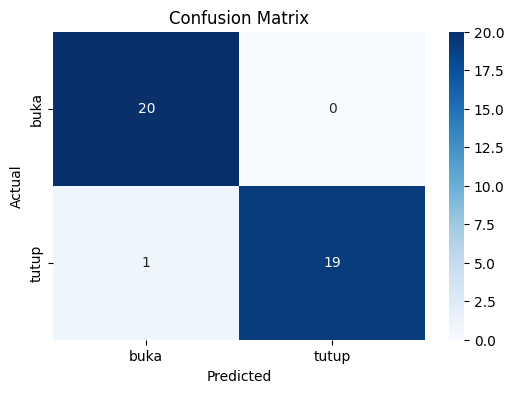

In [7]:
#Visualisasi Model
import matplotlib.pyplot as plt
import seaborn as sns
# Confusion Matrix Visualization
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=categories, yticklabels=categories)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()
